In [2]:
import numpy
import gym
import stable_baselines3 as sb3
import scipy
import mujoco

In [ ]:
import mujoco
import mujoco.viewer
import numpy as np
sat_xml = """<
<mujoco model="satellites">
  <compiler angle="degree"/>
  <option timestep="0.001" gravity="0 0 0"/>
  
  <default>
    <geom contype="1" conaffinity="1" density="1000" friction="0.5 0.005 0.0001"/>
  </default>
  
  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <camera pos="5 0 2" xyaxes="-1 0 0 0 0 1"/>
    
    <!-- Servicing Satellite -->
    <body name="servicer" pos="0 0 0">
      <joint name="servicer_free" type="free"/>
      <!-- Main body -->
      <geom name="servicer_body" type="box" size=".5 .5 .5" rgba="0.7 0.7 0.7 1"/>
      <!-- Docking port (protrusion) -->
      <geom name="servicer_port" type="cylinder" pos="0 0 0.5" size="0.1 0.2" rgba="1 0 0 1"/>
      <!-- Docking site (for reference) -->
      <site name="servicer_dock_site" pos="0 0 0.5" size="0.15" rgba="0 1 0 1"/>
    </body>
    
    <!-- Target Satellite -->
    <body name="target" pos="3 0 0">
      <joint name="target_free" type="free"/>
      <!-- Main body -->
      <geom name="target_body" type="box" size=".5 .5 .5" rgba="0.7 0.7 0.7 1"/>
      <!-- Docking cavity (receptacle) -->
      <geom name="target_cavity" type="cylinder" pos="0 0 -0.5" size="0.15 0.25" rgba="0 0 1 1"/>
      <!-- Docking site (for reference) -->
      <site name="target_dock_site" pos="0 0 -0.5" size="0.15" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>

"""
# Load the model
model = mujoco.MjModel.from_xml_string(sat_xml)

# Create simulation data
data = mujoco.MjData(model)

duration = 5.0  # seconds
dt = model.opt.timestep
steps = int(duration / dt)


sat_positions = np.zeros((steps, 3))
times = np.arange(0, duration, dt)
data.qpos[0:3] = np.array([0, 0, 2])  # x, y, z

# Velocity (x, y, z)
data.qvel[0:3] = np.array([0.5, 0, -1])
# Run simulations
for i in range(steps):
    # Store current positions
    sat_positions[i] = data.qpos[0:3]

    # Step simulation
    mujoco.mj_step(model, data)


ValueError: XML parse error 15:
Error=XML_ERROR_PARSING ErrorID=15 (0xf) Line number=1


In [ ]:
satellites_xml = """
<mujoco model="satellites">
  <compiler angle="degree"/>
  <option timestep="0.001" gravity="0 0 0"/>
  
  <default>
    <geom contype="1" conaffinity="1" density="1000" friction="0.5 0.005 0.0001"/>
  </default>
  
  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <camera pos="5 0 2" xyaxes="-1 0 0 0 0 1"/>
    
    <!-- Servicing Satellite -->
    <body name="servicer" pos="0 0 0">
      <joint name="servicer_free" type="free"/>
      <!-- Main body -->
      <geom name="servicer_body" type="cube" size="0.5" rgba="0.7 0.7 0.7 1"/>
      <!-- Docking port (protrusion) -->
      <geom name="servicer_port" type="cylinder" pos="0 0 0.5" size="0.1 0.2" rgba="1 0 0 1"/>
      <!-- Docking site (for reference) -->
      <site name="servicer_dock_site" pos="0 0 0.5" size="0.15" rgba="0 1 0 1"/>
    </body>
    
    <!-- Target Satellite -->
    <body name="target" pos="3 0 0">
      <joint name="target_free" type="free"/>
      <!-- Main body -->
      <geom name="target_body" type="cube" size="0.5" rgba="0.7 0.7 0.7 1"/>
      <!-- Docking cavity (receptacle) -->
      <geom name="target_cavity" type="cylinder" pos="0 0 -0.5" size="0.15 0.25" rgba="0 0 1 1"/>
      <!-- Docking site (for reference) -->
      <site name="target_dock_site" pos="0 0 -0.5" size="0.15" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""


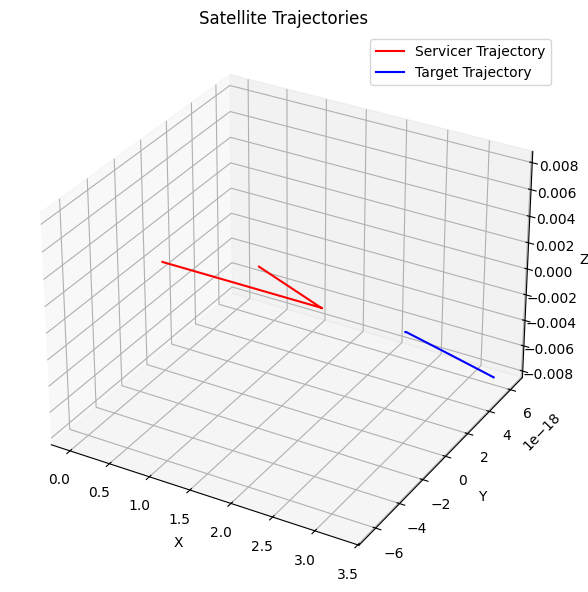

In [18]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directory for output
os.makedirs("output", exist_ok=True)

# Load the satellites XML model from the string
model = mujoco.MjModel.from_xml_string(satellites_xml)
data = mujoco.MjData(model)

# ----- Set Initial Conditions -----
# Servicer starts at (0,0,0) with a velocity toward the target.
data.qpos[0:3] = np.array([0, 0, 0])      # Servicer position
data.qvel[0:3] = np.array([0.5, 0, 0])      # Servicer velocity

# Target starts at (3,0,0) and remains nearly stationary
# The target's free joint occupies positions [7:10] (after servicer's 7 dofs).
target_offset = 7  # free joint adds 7 parameters (3 pos, 4 quat)
data.qpos[target_offset:target_offset+3] = np.array([3, 0, 0])
data.qvel[target_offset:target_offset+3] = np.array([0, 0, 0])

# Simulation parameters
duration = 5.0    # seconds
dt = model.opt.timestep
steps = int(duration / dt)

# Arrays to store positions of the docking sites for each satellite
servicer_positions = np.zeros((steps, 3))
target_positions = np.zeros((steps, 3))
times = np.linspace(0, duration, steps)

# ----- Run Simulation -----
for i in range(steps):
    # Save the positions of the docking sites (which coincide with the geom positions)
    # For this example, we assume the docking site is offset from the body's qpos.
    # Here, we simply record the main body positions.
    servicer_positions[i] = data.qpos[0:3]
    target_positions[i] = data.qpos[target_offset:target_offset+3]
    
    # Step the simulation forward
    mujoco.mj_step(model, data)

# ----- Plot Trajectories -----
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(servicer_positions[:, 0], servicer_positions[:, 1], servicer_positions[:, 2],
        label='Servicer Trajectory', color='red')
ax.plot(target_positions[:, 0], target_positions[:, 1], target_positions[:, 2],
        label='Target Trajectory', color='blue')

# Draw a plane to represent a reference (if needed)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Satellite Trajectories')
ax.legend()
plt.tight_layout()
plt.savefig('output/satellite_trajectories.png')
plt.show()


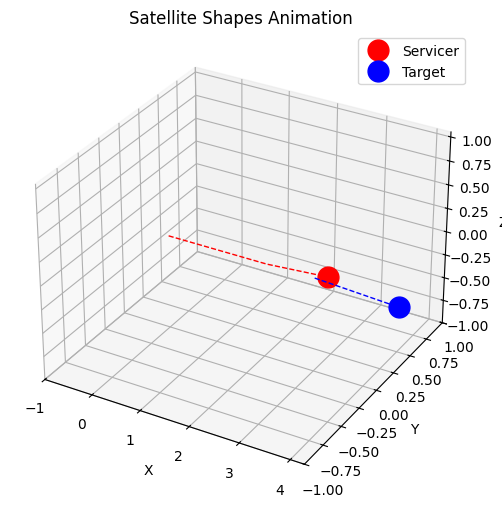

In [21]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# ----- Setup and Simulation -----
os.makedirs("output", exist_ok=True)

# Load the satellites XML model from the string
model = mujoco.MjModel.from_xml_string(satellites_xml)
data = mujoco.MjData(model)

# Set initial conditions for servicer and target
data.qpos[0:3] = np.array([0, 0, 0])      # Servicer position
data.qvel[0:3] = np.array([1, 0, 0])      # Servicer velocity

# Target parameters (free joint with 7 parameters: 3 pos, 4 quat)
target_offset = 7
data.qpos[target_offset:target_offset+3] = np.array([3, 0, 0])
data.qvel[target_offset:target_offset+3] = np.array([0, 0, 0])

# Simulation parameters
duration = 5.0    # seconds
dt = model.opt.timestep
steps = int(duration / dt)

# Arrays to store positions for each satellite
servicer_positions = np.zeros((steps, 3))
target_positions = np.zeros((steps, 3))

# Run simulation and record positions
for i in range(steps):
    servicer_positions[i] = data.qpos[0:3]
    target_positions[i] = data.qpos[target_offset:target_offset+3]
    mujoco.mj_step(model, data)

# ----- Animation Setup -----
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create plot objects for satellites (as markers) and trajectories (as dashed lines)
servicer_point, = ax.plot([], [], [], 'o', color='red', markersize=15, label='Servicer')
target_point, = ax.plot([], [], [], 'o', color='blue', markersize=15, label='Target')
servicer_traj, = ax.plot([], [], [], '--', color='red', linewidth=1)
target_traj, = ax.plot([], [], [], '--', color='blue', linewidth=1)

# Set axis limits based on simulation data (adding a margin)
margin = 1.0
ax.set_xlim(servicer_positions[:,0].min()-margin, servicer_positions[:,0].max()+margin)
ax.set_ylim(servicer_positions[:,1].min()-margin, servicer_positions[:,1].max()+margin)
ax.set_zlim(servicer_positions[:,2].min()-margin, servicer_positions[:,2].max()+margin)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Satellite Shapes Animation')
ax.legend()

# ----- Animation Functions -----
def init():
    # Initialize plot objects to empty data
    servicer_point.set_data([], [])
    servicer_point.set_3d_properties([])
    target_point.set_data([], [])
    target_point.set_3d_properties([])
    servicer_traj.set_data([], [])
    servicer_traj.set_3d_properties([])
    target_traj.set_data([], [])
    target_traj.set_3d_properties([])
    return servicer_point, target_point, servicer_traj, target_traj

def update(frame):
    # Update marker positions for servicer and target
    sx, sy, sz = servicer_positions[frame]
    tx, ty, tz = target_positions[frame]
    servicer_point.set_data([sx], [sy])
    servicer_point.set_3d_properties([sz])
    target_point.set_data([tx], [ty])
    target_point.set_3d_properties([tz])
    
    # Update trajectory lines for both satellites up to current frame
    servicer_traj.set_data(servicer_positions[:frame+1, 0], servicer_positions[:frame+1, 1])
    servicer_traj.set_3d_properties(servicer_positions[:frame+1, 2])
    target_traj.set_data(target_positions[:frame+1, 0], target_positions[:frame+1, 1])
    target_traj.set_3d_properties(target_positions[:frame+1, 2])
    
    return servicer_point, target_point, servicer_traj, target_traj

# Create animation using FuncAnimation
anim = animation.FuncAnimation(fig, update, frames=steps, init_func=init, interval=20, blit=True)

# Save the animation as an MP4 video file (requires ffmpeg)
anim.save('output/satellite_animation.mp4', writer='ffmpeg', fps=1/dt)

plt.show()


In [ ]:
#Define dynamics
#Rigid Body dynamics mujoco shapes






#Define satellites shapes
#Define scenario and enviorment
#Shape Rewards
#Train


In [2]:
import os
import platform
# Set appropriate backend for macOS
if platform.system() == "Darwin":
    os.environ["MUJOCO_GL"] = "glfw"  # macOS native OpenGL context
else:
    os.environ["MUJOCO_GL"] = "osmesa"  # For Linux systems

import mujoco
import numpy as np
import time
import imageio.v2 as imageio
import matplotlib.pyplot as plt  # For debugging
import mediapy as media

# Create output directory
os.makedirs("output", exist_ok=True)

# XML model definition
sat_xml = """<mujoco model="satellites">
  <compiler angle="degree" />
  <option timestep="0.01" gravity="0 0 0" />
  <default>
    <!-- Default geom properties -->
    <geom contype="1" conaffinity="1" friction="0.1" density="1000"/>
  </default>

  <worldbody>
    <!-- Create a camera that follows the servicer -->
    <camera name="trackercam" mode="trackcom" target="servicer" pos="0 -3 0"/>
    <!-- Fixed camera -->
    <camera name="fixed" pos="5 0 0" xyaxes="-1 0 0 0 1 0"/>
    
    <!-- Lighting -->
    <light directional="true" diffuse=".8 .8 .8" specular=".2 .2 .2" pos="0 0 5" dir="0 0 -1"/>
    
    <!-- Servicer Satellite -->
    <body name="servicer" pos="0 0 0">
      <freejoint/>
      <!-- Main body (e.g., sphere) -->
      <geom type="box" size=".5 .5 .5" rgba="0.7 0.7 0.7 1"/>
      <!-- Docking port protrusion -->
      <geom name="servicer_dock_port" type="cylinder" pos="0 0 0.5" size="0.1 0.2" euler="0 0 0" rgba="1 0 0 1"/>
      <!-- Docking detection site -->
      <site name="servicer_dock_site" pos="0 0 0.5" size="0.15" rgba="0 1 0 0.5" />
    </body>

    <!-- Target Satellite -->
    <body name="target" pos="0 0 2">
      <freejoint/>
      <!-- Main body (e.g., sphere) -->
      <geom type="box" size=".5 .5 .5" rgba="0.7 0.7 0.7 1"/>
      <!-- Docking cavity (for receiving the docking port) -->
      <geom name="target_dock_cavity" type="cylinder" pos="0 0 -0.5" size="0.15 0.25" euler="0 0 0" rgba="0 0 1 1"/>
      <!-- Docking detection site -->
      <site name="target_dock_site" pos="0 0 -0.5" size="0.15" rgba="0 1 0 0.5" />
    </body>
  </worldbody>
  


  <tendon>
    <!-- Optional: Tendon to visualize distance between docking sites -->
    <spatial limited="false" width="0.01" rgba="1 1 0 0.5">
      <site site="servicer_dock_site"/>
      <site site="target_dock_site"/>
    </spatial>
  </tendon>

  <visual>
    <global offwidth="1920" offheight="1080" />
  </visual>
</mujoco>
"""

# Load the model
model = mujoco.MjModel.from_xml_string(sat_xml)

# Create simulation data
data = mujoco.MjData(model)

# Set initial conditions
# Servicer position and velocity
data.qpos[0:3] = np.array([0, 0, 0])      # x, y, z position
data.qpos[3:7] = np.array([1, 0, 0, 0])   # quaternion orientation
data.qvel[0:3] = np.array([1, 0, 0])      # velocity

# Target position and velocity (7 DOF offset for the second free joint)
target_offset = 7
data.qpos[target_offset:target_offset+3] = np.array([3, 0, 0])  # position
data.qpos[target_offset+3:target_offset+7] = np.array([1, 0, 0, 0])  # orientation
data.qvel[target_offset:target_offset+3] = np.array([0, 0, 1])  # velocity

# Simulation parameters
duration = 15.0  # seconds
dt = model.opt.timestep
fps = 30  # Frames per second for rendering
render_every = int(1.0 / (dt * fps))  # How many simulation steps between renders

# Setup for recording
record = True
video_path = os.path.join("output", "satellite_simulation.mp4")
width, height = 640, 480

# Option 1: Interactive viewer without recording
def run_interactive():
    # Initialize the viewer
    with mujoco.viewer.launch_passive(model, data) as viewer:
        # Initial sync
        viewer.sync()
        
        # Run simulation with rendering
        step_count = 0
        start_time = time.time()
        sim_time = 0
        
        while sim_time < duration:
            # Step the simulation
            mujoco.mj_step(model, data)
            sim_time += dt
            step_count += 1
            
            # Only render at the specified FPS
            if step_count % render_every == 0:
                # Update visualization
                viewer.sync()
                
                # Optional: add time delay to watch in real-time
                elapsed = time.time() - start_time
                if elapsed < sim_time:
                    time.sleep(sim_time - elapsed)
        
        # Keep the viewer open for a moment to see the final state
        time.sleep(1.0)

# Option 2: Render to offscreen buffer and save video
duration = 10  # (seconds)
framerate = 60  # (Hz)
frames = []
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
#mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

# Choose which method to use


print("Simulation complete!")



Simulation complete!


In [11]:
import gym
from gym import spaces
import numpy as np
import mujoco
import os
import platform

# Setup rendering backend
if platform.system() == "Darwin":
    os.environ["MUJOCO_GL"] = "glfw"
else:
    os.environ["MUJOCO_GL"] = "osmesa"

class SatelliteEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self.model = mujoco.MjModel.from_xml_string(sat_xml)
        self.data = mujoco.MjData(self.model)

        self.obs_dim = 6  # example: relative pos/vel (can be more detailed)
        self.action_dim = 3  # example: force on servicer

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self.action_dim,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)

        mujoco.mj_resetData(self.model, self.data)

        # Initialize state
        self.data.qpos[:3] = [0, 0, 0]
        self.data.qpos[3:7] = [1, 0, 0, 0]
        self.data.qvel[:3] = [0, 0, 0]

        offset = 7
        self.data.qpos[offset:offset+3] = [3, 0, 0]
        self.data.qpos[offset+3:offset+7] = [1, 0, 0, 0]
        self.data.qvel[offset:offset+3] = [0, 0, 0]

        return self._get_obs(), {}

    def step(self, action):
        action = np.clip(action, -1.0, 1.0)
        self.data.xfrc_applied[0, :3] = action * 10.0

        mujoco.mj_step(self.model, self.data)

        obs = self._get_obs()
        dock_dist = np.linalg.norm(self._dock_error())

        reward = -dock_dist
        terminated = np.linalg.norm(obs[:3]) < 0.01  # success if docked
        truncated = False  # You can set this based on max steps or time

        return obs, reward, terminated, truncated, {}
    def _dock_error(self):
        sid1 = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SITE, "servicer_dock_site")
        sid2 = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SITE, "target_dock_site")
        return self.data.site_xpos[sid2] - self.data.site_xpos[sid1]

    def _get_obs(self):
        pos1 = self.data.qpos[:3]
        pos2 = self.data.qpos[7:10]
        vel1 = self.data.qvel[:3]
        vel2 = self.data.qvel[7:10]
        return np.concatenate([pos2 - pos1, vel2 - vel1], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            # Use mujoco_viewer package instead of mujoco.viewer
            self.viewer = mujoco_viewer.MujocoViewer(self.model, self.data)
            
        if mode == "human":
            self.viewer.render()
            return None
        elif mode == "rgb_array":
            # Return RGB array for video recording
            return self.viewer.read_pixels(self.width, self.height)

    def close(self):
        if hasattr(self, "viewer"):
            self.viewer.close()
from stable_baselines3 import PPO

env = SatelliteEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

model.save("ppo_satellite_docking")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/mj_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 7918 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4996        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009775423 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 823         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00358    |
|    std                  | 0.988       |
|    value_loss           | 2.1e+03     |
----------------------------------

In [4]:
from stable_baselines3 import PPO
import time

# Load trained model
#model = PPO.load(".zip")

# Create env (same as during training)
env = SatelliteEnv()

obs = env.reset()[0]  # for gym>=0.26
done = False

# Optional: real-time viewer
env.render()

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(env.model.opt.timestep)  # slow down for visibility

env.close()
import imageio

frames = []
obs = env.reset()[0]
done = False

while not done:
    frame = env.render(mode="rgb_array")  # requires proper render implementation
    frames.append(frame)
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

# Save as video
imageio.mimsave("docking_test.mp4", frames, fps=30)


AttributeError: module 'mujoco' has no attribute 'viewer'

In [12]:
from stable_baselines3 import PPO
import time
import imageio
import numpy as np

# Assuming you have the SatelliteEnv class defined elsewhere
# and it's imported properly at the top of your script

# Create env
env = SatelliteEnv()

# For demonstration, we'll use random actions
# But you can uncomment the model loading part if you have a trained model
# model = PPO.load("ppo_satellite_docking")

# Option 1: Real-time visualization (using random actions if no model available)
def visualize_realtime():
    obs = env.reset()  # No need for [0] with regular gym
    done = False
    
    # If you have a trained model:
    # while not done:
    #     action, _ = model.predict(obs, deterministic=True)
    #     obs, reward, done, info = env.step(action)
    #     env.render()
    #     time.sleep(env.model.opt.timestep)  # slow down for visibility
    
    # For testing without a model (random actions):
    for _ in range(200):  # Run for 200 steps or until done
        action = env.action_space.sample()  # Random action
        obs, reward, done, info = env.step(action)
        env.render()
        time.sleep(env.model.opt.timestep)
        if done:
            break
    
    env.close()

# Option 2: Save as video
def create_video():
    frames = []
    obs = env.reset()  # No need for [0] with regular gym
    done = False
    
    # If you have a trained model:
    # while not done:
    #     action, _ = model.predict(obs, deterministic=True)
    #     obs, reward, done, info = env.step(action)
    #     frame = env.render(mode="rgb_array")
    #     frames.append(frame)
    
    # For testing without a model (random actions):
    for _ in range(200):  # Run for 200 steps or until done
        action = env.action_space.sample()  # Random action
        obs, reward, terminated,truncated, info = env.step(action)
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        if done:
            break
    
    # Convert frames to uint8 if they aren't already
    frames = [frame.astype(np.uint8) if frame.dtype != np.uint8 else frame for frame in frames]
    
    # Save as video
    imageio.mimsave("docking_test.mp4", frames, fps=30)
    print("Video saved as docking_test.mp4")
def create_video(env, steps=200, filename="docking_test.mp4"):
    frames = []
    obs = env.reset()
    done = False
    
    for _ in range(steps):  # Run for specified steps or until done
        action = env.action_space.sample()  # Random action
        obs, reward, done,truncated, info = env.step(action)
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        if done:
            break
    
    # Convert frames to uint8 if they aren't already
    frames = [frame.astype(np.uint8) if frame.dtype != np.uint8 else frame for frame in frames]
    
    # Save as video
    imageio.mimsave(filename, frames, fps=30)
    print(f"Video saved as {filename}")
    
    env.close()


create_video(env)

AttributeError: 'SatelliteEnv' object has no attribute 'viewer'